In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from matplotlib_venn import venn3
import os


In [2]:
# Charger les données
X = pd.read_csv("data/X_final.csv")
y = pd.read_csv("data/y.csv").squeeze()  # transforme en série

print("Dimensions :", X.shape, y.shape)

Dimensions : (98053, 54) (98053,)


In [3]:
# Identifier les colonnes constantes
constant_cols = [col for col in X.columns if X[col].nunique() <= 1]

# Affichage des colonnes concernées
if constant_cols:
    print(f"{len(constant_cols)} variable(s) constante(s) détectée(s) :")
    print(constant_cols)
    
    # Suppression
    X = X.drop(columns=constant_cols)
    print(f"Nouveau nombre de variables : {X.shape[1]}")
else:
    print("Aucune variable constante détectée.")


5 variable(s) constante(s) détectée(s) :
['examide', 'citoglipton', 'metformin-rosiglitazone', 'change', 'diabetesMed']
Nouveau nombre de variables : 49


In [ ]:
# diag_1, diag_2, diag_3 sont des codes ICD-9. On les regroupe en catégories médicales.

def map_icd9(code):
    if code.startswith('V') or code.startswith('E'):
        return 'Other'
    try:
        c = float(code)
    except:
        return 'Other' 
    if 390 <= c <= 459 or c == 785: return 'Circulatory'
    if 460 <= c <= 519 or c == 786: return 'Respiratory'
    if 520 <= c <= 579 or c == 787: return 'Digestive'
    if str(int(c)).startswith('250'): return 'Diabetes'
    if 800 <= c <= 999: return 'Injury'
    if 710 <= c <= 739: return 'Musculoskeletal'
    if 580 <= c <= 629 or c == 788: return 'Genitourinary'
    if 140 <= c <= 239: return 'Neoplasms'
    return 'Other'

for col in ['diag_1', 'diag_2', 'diag_3']:
    X[col] = X[col].astype(str).apply(map_icd9)


In [5]:
# Identifie les colonnes non numériques (normalement diag_1, diag_2, diag_3)
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
print("Colonnes non numériques :", list(non_numeric_cols))

# Encodage ordinal
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[non_numeric_cols] = encoder.fit_transform(X[non_numeric_cols])

# Vérification
print(X.dtypes.value_counts())


Colonnes non numériques : ['diag_1', 'diag_2', 'diag_3']
float64    29
int64      20
Name: count, dtype: int64


✔ Nombre optimal de variables k : 31
✔ Variables sélectionnées (support mask) : [False  True False  True False  True  True False  True  True  True  True
 False  True  True False False  True  True  True  True False  True  True
  True  True  True False False  True  True  True  True  True False  True
  True  True  True False  True  True False False False  True False False
 False]


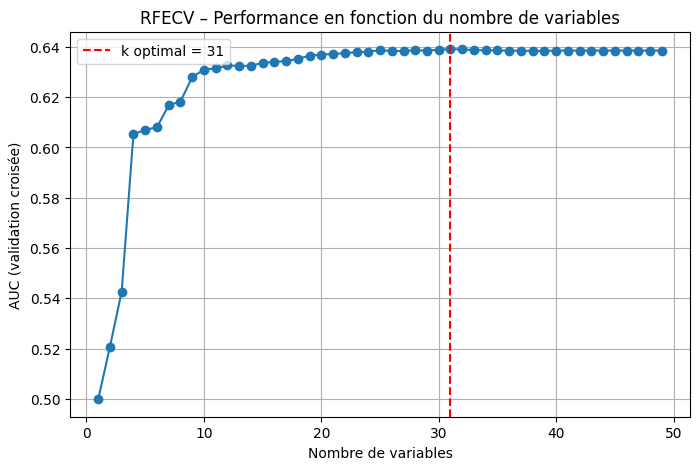

✔ AUC TEST : 0.6344794268440721


In [6]:
# Détermination du nombre optimal de variables par cross-validation avec RFECV

# 1) Train / Test split (évite l'optimisme)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# 2) Modèle
logreg = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    class_weight="balanced",
    max_iter=3000
)

# 3) RFECV → sélection multivariée + détermination automatique de k
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rfecv = RFECV(
    estimator=logreg,
    step=1,                 
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

# 4) Pipeline
pipeline = Pipeline([
    ("rfecv", rfecv)
])

pipeline.fit(X_train, y_train)

# 5) Résultats : nombre optimal de variables
optimal_k = pipeline.named_steps["rfecv"].n_features_
support = pipeline.named_steps["rfecv"].support_
ranking = pipeline.named_steps["rfecv"].ranking_

print("✔ Nombre optimal de variables k :", optimal_k)
print("✔ Variables sélectionnées (support mask) :", support)

# 7) Graphique performance (AUC) en fonction du nombre de features
results = rfecv.cv_results_
mean_scores = results["mean_test_score"]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(mean_scores) + 1), mean_scores, marker='o')
plt.axvline(optimal_k, color='red', linestyle='--', label=f"k optimal = {optimal_k}")
plt.xlabel("Nombre de variables")
plt.ylabel("AUC (validation croisée)")
plt.title("RFECV – Performance en fonction du nombre de variables")
plt.grid(True)
plt.legend()
plt.show()


# 8) Score Final TEST
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)

print("✔ AUC TEST :", test_auc)


In [7]:
# Sélection selon l'information mutuelle
selector = SelectKBest(score_func=mutual_info_classif, k='all')
X_selected = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
scores = selector.scores_[selector.get_support()]

# Affichage
feat_scores = pd.DataFrame({'Variable': selected_features, 'Score': scores})
feat_scores.sort_values('Score', ascending=False, inplace=True)
print(feat_scores)


                    Variable     Score
9           number_inpatient  0.016941
12            race_Caucasian  0.015970
1   discharge_disposition_id  0.012075
15               gender_Male  0.011397
26                    diag_1  0.005118
28                    diag_3  0.005029
3           time_in_hospital  0.004989
10          number_diagnoses  0.004732
7          number_outpatient  0.004619
8           number_emergency  0.004551
0          admission_type_id  0.004086
44                   insulin  0.004085
27                    diag_2  0.003704
23               age_[70-80)  0.003302
2        admission_source_id  0.003120
5             num_procedures  0.002864
29                 metformin  0.002514
20               age_[40-50)  0.002053
34             acetohexamide  0.001995
16    gender_Unknown/Invalid  0.001731
42              troglitazone  0.001560
36                 glyburide  0.001437
14                race_Other  0.001403
6            num_medications  0.001167
32            chlorpropam

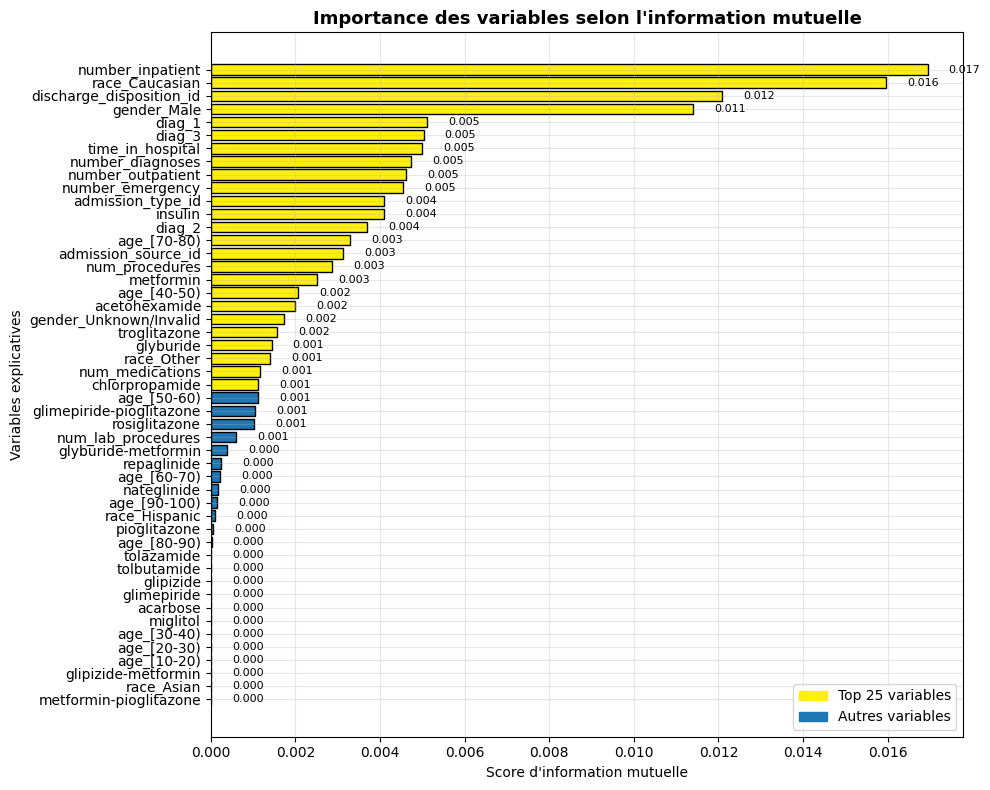

In [8]:
# Tri des variables par score décroissant
feat_scores_sorted = feat_scores.sort_values('Score', ascending=False).reset_index(drop=True)

# TOP 25 variables
top_k = 25
feat_scores_sorted['Couleur'] = [
    "#ffef0eff" if i < top_k else '#1f77b4'
    for i in range(len(feat_scores_sorted))
]

# Visualisation 
plt.figure(figsize=(10, 8))
plt.barh(
    feat_scores_sorted['Variable'],
    feat_scores_sorted['Score'],
    color=feat_scores_sorted['Couleur'],
    edgecolor='black'
)

plt.title("Importance des variables selon l'information mutuelle", fontsize=13, weight='bold')
plt.xlabel("Score d'information mutuelle")
plt.ylabel("Variables explicatives")
plt.gca().invert_yaxis()

# Valeurs sur les barres 
for i, v in enumerate(feat_scores_sorted['Score']):
    plt.text(v + 0.0005, i, f"{v:.3f}", va='center', fontsize=8)

# Légende simple
plt.legend(
    handles=[
        plt.Rectangle((0, 0), 1, 1, color='#ffef0eff', label='Top 25 variables'),
        plt.Rectangle((0, 0), 1, 1, color='#1f77b4', label='Autres variables')
    ],
    loc='best'
)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Train shape : (78442, 49)
Test shape : (19611, 49)
Tune shape : (20000, 49)

Meilleur C sélectionné : 0.01291549665014884

Variables sélectionnées : 21


,Variable,Coefficient,Abs_Coefficient,Selected
9,number_inpatient,0.361105,0.361105,True
1,discharge_disposition_id,0.132393,0.132393,True
21,age_[50-60),-0.112234,0.112234,True
10,number_diagnoses,0.094213,0.094213,True
8,number_emergency,0.072216,0.072216,True
3,time_in_hospital,0.071356,0.071356,True
29,metformin,-0.063346,0.063346,True
5,num_procedures,-0.061632,0.061632,True
24,age_[80-90),0.056126,0.056126,True
23,age_[70-80),0.055815,0.055815,True


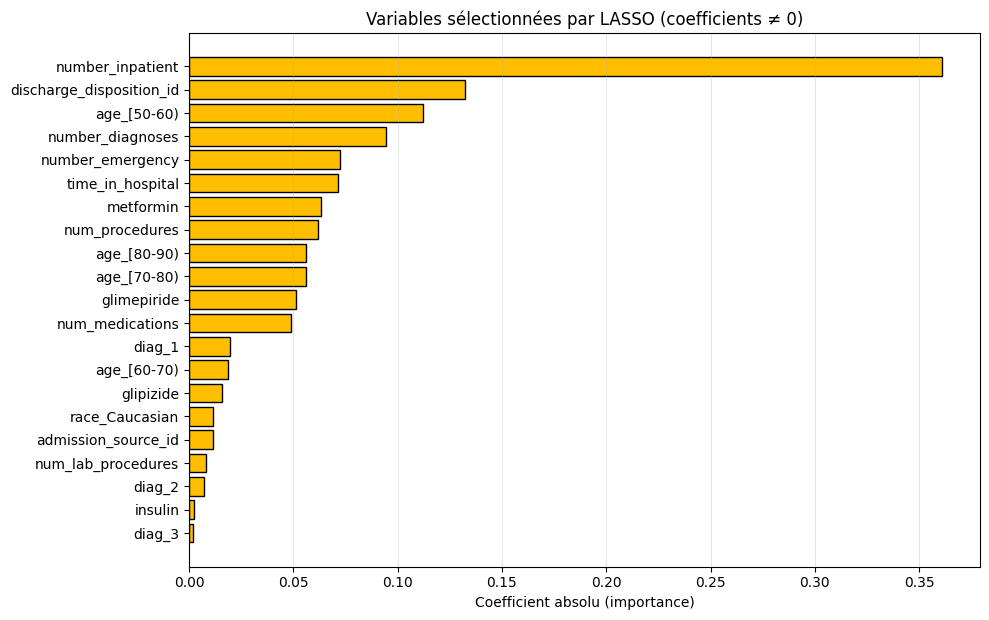

In [9]:
# LASSO Logistic Regression avec sélection des variables (version optimisée)

# 1) TRAIN / TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape :", X_train.shape)
print("Test shape :", X_test.shape)

# 1bis) SOUS-ÉCHANTILLON POUR LA CV (20k lignes = idéal)
X_tune, _, y_tune, _ = train_test_split(
    X_train, y_train,
    train_size=20000,
    stratify=y_train,
    random_state=42
)

print("Tune shape :", X_tune.shape)

# 2) CV RAPIDE POUR TROUVER LE MEILLEUR C
log_reg_cv = LogisticRegressionCV(
    Cs=np.logspace(-3, 2, 10),
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    penalty='l1',
    solver='liblinear',
    scoring='roc_auc',
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    n_jobs=-1,
    refit=True
)

log_reg_cv.fit(X_tune, y_tune)

best_C = log_reg_cv.C_[0]
print("\nMeilleur C sélectionné :", best_C)

# 3) MODELE LASSO FINAL SUR TOUT LE TRAIN
final_lasso = LogisticRegression(
    C=best_C,
    penalty='l1',
    solver='liblinear',
    class_weight='balanced',
    max_iter=2000,
    random_state=42
)

final_lasso.fit(X_train, y_train)

# 4) EXTRACTION DES COEFFS
coef = final_lasso.coef_[0]
variables = X.columns

lasso_df = pd.DataFrame({
    'Variable': variables,
    'Coefficient': coef,
    'Abs_Coefficient': np.abs(coef),
    'Selected': coef != 0
})

# Trier par importance
lasso_df_sorted = lasso_df.sort_values('Abs_Coefficient', ascending=False)

# Garder les variables sélectionnées
selected_vars = lasso_df_sorted[lasso_df_sorted['Selected']]

print("\nVariables sélectionnées :", selected_vars.shape[0])
display(selected_vars)

# 5) PLOT
plt.figure(figsize=(10, max(6, len(selected_vars)*0.3)))
plt.barh(
    selected_vars['Variable'],
    selected_vars['Abs_Coefficient'],
    color="#ffbf00",
    edgecolor="black"
)
plt.xlabel("Coefficient absolu (importance)")
plt.title("Variables sélectionnées par LASSO (coefficients ≠ 0)")
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


Train shape : (78442, 49)
Test shape : (19611, 49)


/Users/violetteseptier/Desktop/projet/applied/env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✔ Meilleurs hyperparamètres : {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 250, 'subsample': 0.8}
✔ Meilleur score CV AUC : 0.6733925837292274


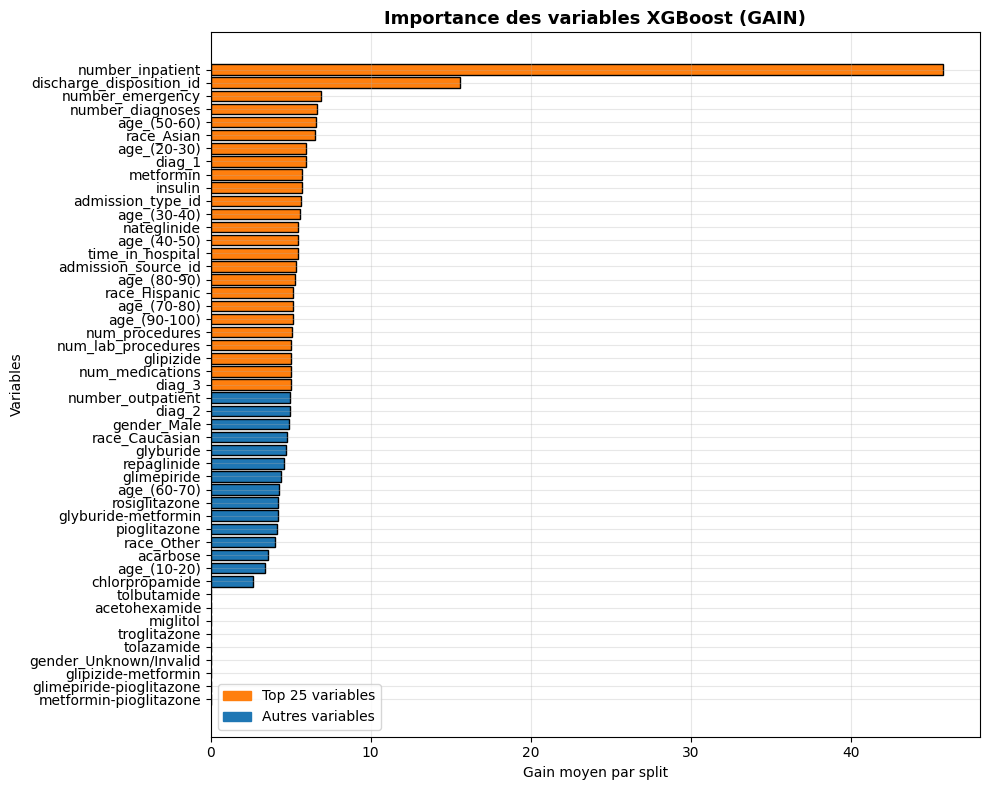

✔ AUC TEST : 0.6701


In [10]:

# importance des variables avec XGBoost (gain)

# 0) Nettoyage des noms de colonnes AVANT le split
X = X.copy()
X.columns = X.columns.astype(str)
X.columns = (
    X.columns.str.replace('[', '(', regex=False)
              .str.replace(']', ')', regex=False)
              .str.replace('<', 'inf', regex=False)
              .str.replace('>', 'sup', regex=False)
)

# 1) TRAIN / TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



print("Train shape :", X_train.shape)
print("Test shape :", X_test.shape)

# 2) GRIDSEARCHCV (optimisation des hyperparamètres)

param_grid = {
    "n_estimators": [150, 250],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb_base = XGBClassifier(
    random_state=42,
    eval_metric="logloss",
    tree_method="hist",
    n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)




grid.fit(X_train, y_train)

print("✔ Meilleurs hyperparamètres :", grid.best_params_)
print("✔ Meilleur score CV AUC :", grid.best_score_)


# 3) ENTRAÎNEMENT FINAL AVEC LES MEILLEURS PARAMÈTRES

best_xgb = grid.best_estimator_
best_xgb.fit(X_train, y_train)


# 4) IMPORTANCE DES VARIABLES BASÉE SUR LE GAIN

booster = best_xgb.get_booster()
gain_dict = booster.get_score(importance_type='gain')

xgb_gain = pd.DataFrame({
    "Variable": gain_dict.keys(),
    "Importance_gain": gain_dict.values()
})

# Mettre 0 pour les variables jamais utilisées
all_vars = pd.DataFrame({"Variable": X_train.columns})
xgb_gain = all_vars.merge(xgb_gain, on="Variable", how="left").fillna(0)

# Tri décroissant
xgb_gain = xgb_gain.sort_values("Importance_gain", ascending=False).reset_index(drop=True)


# 5) ON GARDE k=25 
top_k = 25
xgb_gain["Couleur"] = ["#ff7f0e" if i < top_k else "#1f77b4" 
                       for i in range(len(xgb_gain))]


# 6) VISUALISATION 

plt.figure(figsize=(10, 8))
plt.barh(
    xgb_gain["Variable"],
    xgb_gain["Importance_gain"],
    color=xgb_gain["Couleur"],
    edgecolor="black"
)
plt.gca().invert_yaxis()

plt.title("Importance des variables XGBoost (GAIN)", fontsize=13, weight="bold")
plt.xlabel("Gain moyen par split")
plt.ylabel("Variables")

plt.legend(
    handles=[
        plt.Rectangle((0, 0), 1, 1, color="#ff7f0e", label=f"Top {top_k} variables"),
        plt.Rectangle((0, 0), 1, 1, color="#1f77b4", label="Autres variables")
    ],
    loc="best"
)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 7) PERFORMANCE FINALE SUR LE TEST

y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)

print("✔ AUC TEST :", round(test_auc, 4))


In [11]:
# --- INFORMATION MUTUELLE ---
mi_rank = feat_scores[['Variable', 'Score']].copy()
mi_rank.rename(columns={'Score': 'MI_Score'}, inplace=True)

# --- LASSO ---
lasso_rank = lasso_df_sorted[['Variable', 'Abs_Coefficient']].copy()
lasso_rank.rename(columns={'Abs_Coefficient': 'LASSO_Score'}, inplace=True)


# --- XGBOOST ---
xgb_rank = xgb_gain[['Variable', 'Importance_gain']].copy()
xgb_rank.rename(columns={'Importance_gain': 'XGB_Gain'}, inplace=True)

# --- MERGE ---
merged = (
    mi_rank.merge(lasso_rank, on='Variable', how='outer')
           .merge(xgb_rank, on='Variable', how='outer')
)

# Remplacer NaN par 0 (si une méthode ne sélectionne pas une variable)
merged.fillna(0, inplace=True)

display(merged)


,Variable,MI_Score,LASSO_Score,XGB_Gain
0,acarbose,0.000000,0.000000,3.566388
1,acetohexamide,0.001995,0.000000,0.000000
2,admission_source_id,0.003120,0.011558,5.311004
3,admission_type_id,0.004086,0.000000,5.633355
4,age_(10-20),0.000000,0.000000,3.377740
5,age_(20-30),0.000000,0.000000,5.970951
6,age_(30-40),0.000000,0.000000,5.606007
7,age_(40-50),0.000000,0.000000,5.451874
8,age_(50-60),0.000000,0.000000,6.575016
9,age_(60-70),0.000000,0.000000,4.288651


In [12]:
# --- 1. Calcul des rangs individuels ---
merged['MI_rank'] = merged['MI_Score'].rank(ascending=False, method='min')
merged['LASSO_rank'] = merged['LASSO_Score'].rank(ascending=False, method='min')
merged['XGB_rank'] = merged['XGB_Gain'].rank(ascending=False, method='min')

# --- 2. Score de Borda ---
N = len(merged)

merged['MI_borda'] = N - merged['MI_rank'] + 1
merged['LASSO_borda'] = N - merged['LASSO_rank'] + 1
merged['XGB_borda'] = N - merged['XGB_rank'] + 1

merged['Borda_total'] = (
    merged['MI_borda'] +
    merged['LASSO_borda'] +
    merged['XGB_borda']
)

# --- 3. Moyenne des rangs ---
merged['Mean_rank'] = (
    merged[['MI_rank', 'LASSO_rank', 'XGB_rank']]
    .mean(axis=1)
)

# --- 4. Classement final ---
final_ranking = merged.sort_values([
    'Mean_rank',        # classement principal
    'Borda_total'       # critère secondaire
], ascending=[True, False])

display(final_ranking)


,Variable,MI_Score,LASSO_Score,XGB_Gain,MI_rank,LASSO_rank,XGB_rank,MI_borda,LASSO_borda,XGB_borda,Borda_total,Mean_rank
45,number_inpatient,0.016941,0.361105,45.797115,1.0,1.0,1.0,58.0,58.0,58.0,174.0,1.000000
26,discharge_disposition_id,0.012075,0.132393,15.606703,3.0,2.0,2.0,56.0,57.0,57.0,170.0,2.333333
43,number_diagnoses,0.004732,0.094213,6.617550,8.0,4.0,4.0,51.0,55.0,55.0,161.0,5.333333
44,number_emergency,0.004551,0.072216,6.883965,10.0,5.0,3.0,49.0,54.0,56.0,159.0,6.000000
23,diag_1,0.005118,0.019670,5.947845,5.0,13.0,8.0,54.0,46.0,51.0,151.0,8.666667
54,time_in_hospital,0.004989,0.071356,5.440704,7.0,6.0,15.0,52.0,53.0,44.0,149.0,9.333333
36,metformin,0.002514,0.063346,5.725294,17.0,7.0,9.0,42.0,52.0,50.0,144.0,11.000000
35,insulin,0.004085,0.002484,5.719436,12.0,20.0,10.0,47.0,39.0,49.0,135.0,14.000000
3,admission_type_id,0.004086,0.000000,5.633355,11.0,22.0,11.0,48.0,37.0,48.0,133.0,14.666667
42,num_procedures,0.002864,0.061632,5.090612,16.0,8.0,21.0,43.0,51.0,38.0,132.0,15.000000


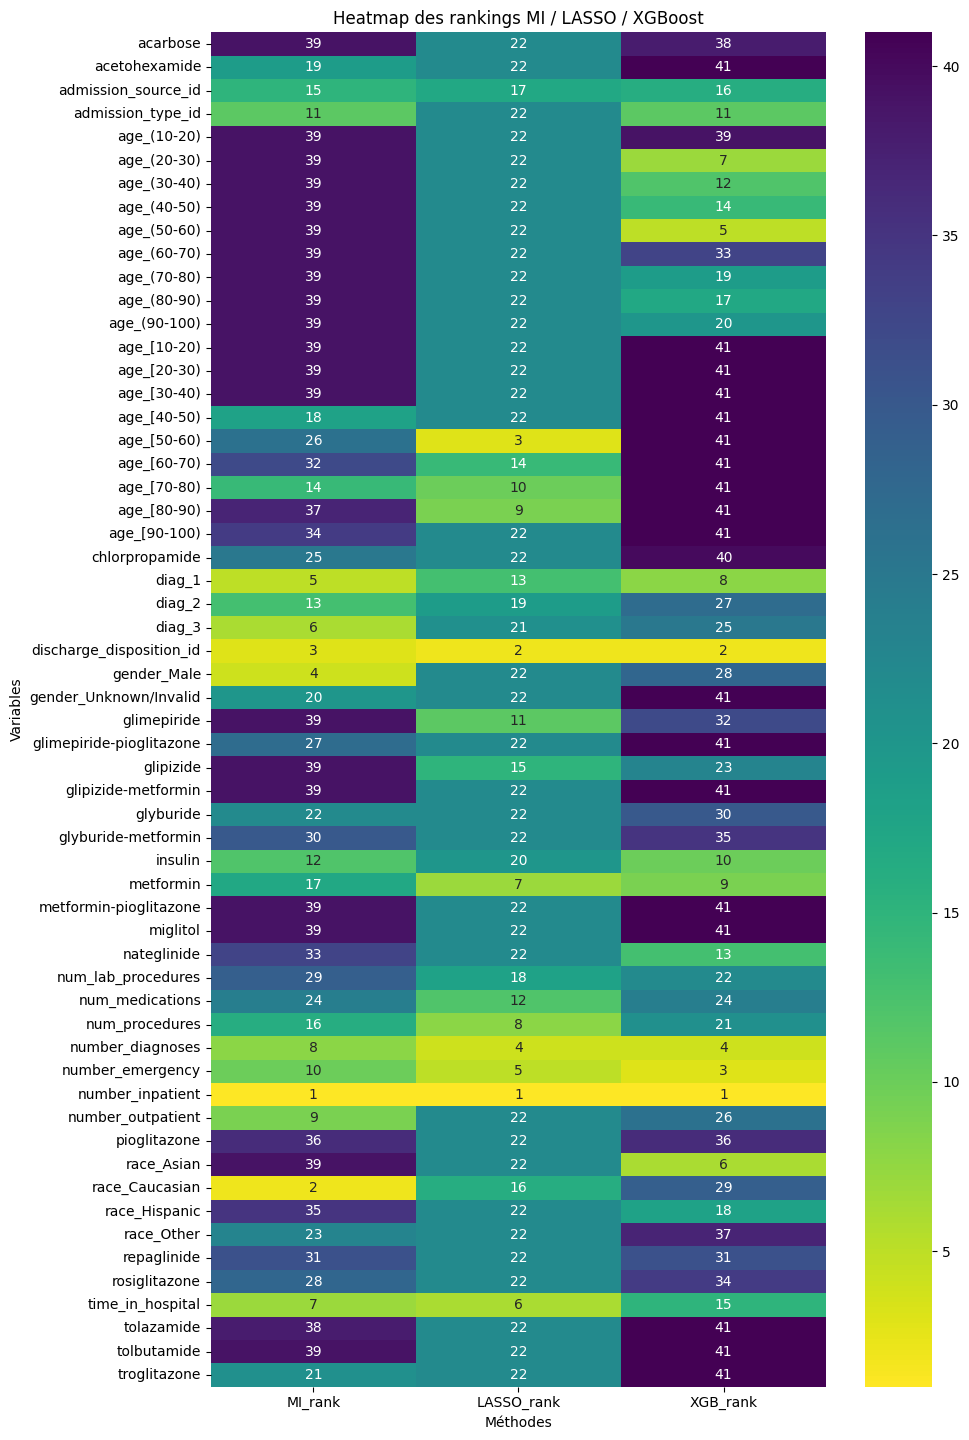

In [13]:
import seaborn as sns

# Sélection des colonnes à afficher
heatmap_data = merged[['Variable', 'MI_rank', 'LASSO_rank', 'XGB_rank']].copy()
heatmap_data.set_index('Variable', inplace=True)

plt.figure(figsize=(10, max(6, len(heatmap_data)*0.25)))
sns.heatmap(heatmap_data, cmap="viridis_r", annot=True, fmt=".0f")
plt.title("Heatmap des rankings MI / LASSO / XGBoost")
plt.ylabel("Variables")
plt.xlabel("Méthodes")
plt.tight_layout()
plt.show()


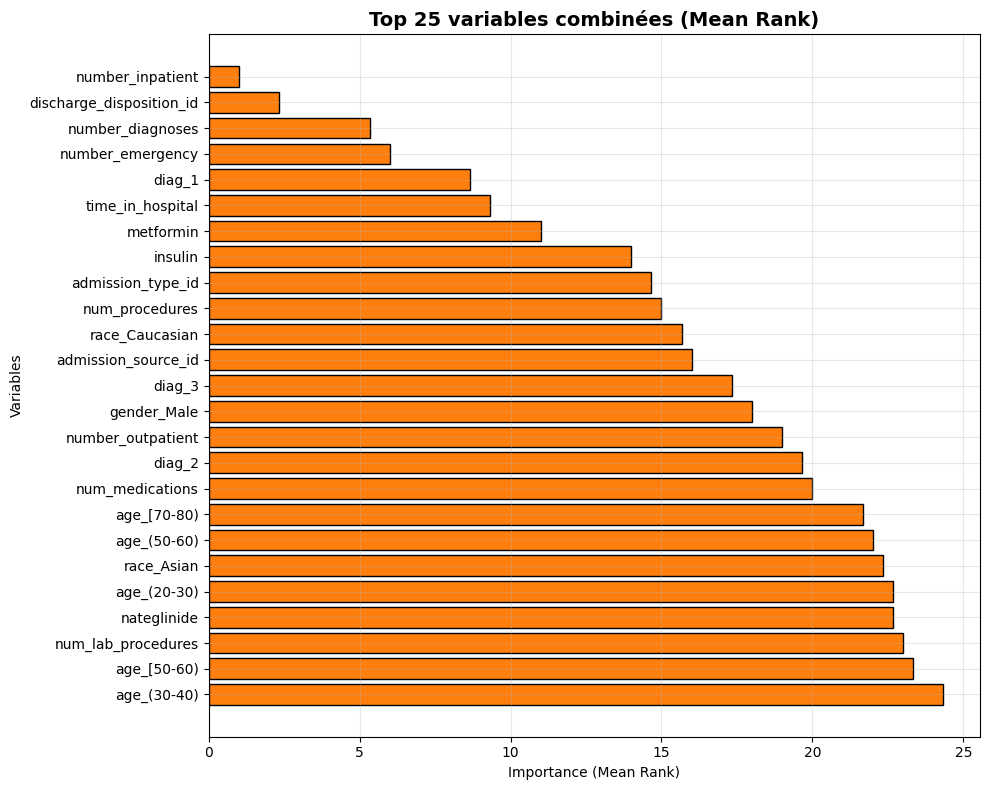

In [14]:
top_combined = final_ranking.head(25).copy()

plt.figure(figsize=(10, 8))
plt.barh(
    top_combined['Variable'],
    top_combined['Mean_rank'],  
    color="#ff7f0e",
    edgecolor="black"
)

plt.title("Top 25 variables combinées (Mean Rank)", fontsize=14, weight="bold")
plt.xlabel("Importance (Mean Rank)")
plt.ylabel("Variables")
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



 Tableau d'appartenance trié (plus de 'Oui' en haut) :


,Variable,In_MI,In_LASSO,In_XGB,Nb_oui
0,diag_3,True,True,True,3
16,admission_source_id,True,True,True,3
39,num_procedures,True,True,True,3
36,diag_1,True,True,True,3
35,metformin,True,True,True,3
6,number_diagnoses,True,True,True,3
32,discharge_disposition_id,True,True,True,3
31,insulin,True,True,True,3
29,time_in_hospital,True,True,True,3
11,number_emergency,True,True,True,3


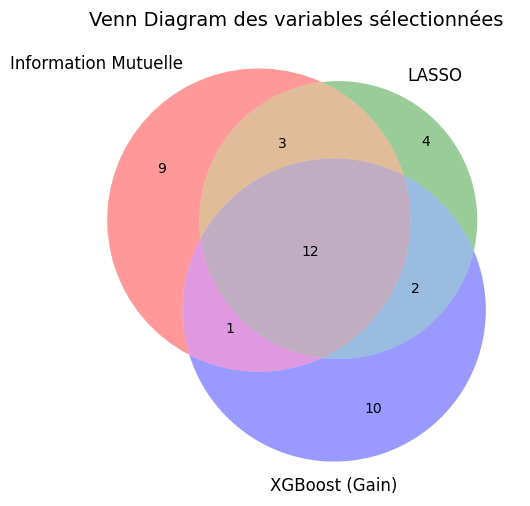

In [15]:


#  Définition des ensembles 
mi_set = set(mi_rank.sort_values('MI_Score', ascending=False).head(25)['Variable'])
lasso_set = set(lasso_rank[lasso_rank['LASSO_Score'] > 0]['Variable'])
xgb_set = set(xgb_rank.sort_values('XGB_Gain', ascending=False).head(25)['Variable'])


# 1) TABLEAU D'APPARTENANCE DES VARIABLES 


# Ensemble total des variables présentes dans au moins un set
all_vars = mi_set | lasso_set | xgb_set

# Construction du tableau 
membership_df = pd.DataFrame({
    "Variable": list(all_vars),
    "In_MI": [var in mi_set for var in all_vars],
    "In_LASSO": [var in lasso_set for var in all_vars],
    "In_XGB": [var in xgb_set for var in all_vars]
})

# Ajouter une colonne : nombre de méthodes où la variable apparaît
membership_df["Nb_oui"] = membership_df[["In_MI", "In_LASSO", "In_XGB"]].sum(axis=1)

# Trier par Nb_oui décroissant
membership_df = membership_df.sort_values(by="Nb_oui", ascending=False)

# Affichage final
print("\n Tableau d'appartenance trié (plus de 'Oui' en haut) :")
display(membership_df[["Variable", "In_MI", "In_LASSO", "In_XGB", "Nb_oui"]])

# 2) VENN DIAGRAM

plt.figure(figsize=(8, 6))
venn3([mi_set, lasso_set, xgb_set],
      ('Information Mutuelle', 'LASSO', 'XGBoost (Gain)'))
plt.title("Venn Diagram des variables sélectionnées", fontsize=14)
plt.show()




In [16]:
# 1) Récupération et correction des noms
top25_vars = (
    final_ranking.head(25)["Variable"]
    .str.replace("[", "(", regex=False)
    .str.replace("]", ")", regex=False)
    .tolist()
)

# 2) Filtrage : on garde uniquement les colonnes qui existent dans X
top25_vars = [v for v in top25_vars if v in X.columns]

# 3) Extraction dans X
top25_dataset = X[top25_vars].copy()

# 4) Enregistrement
output_path = os.path.join("data", "base_top25_variables.csv")
top25_dataset.to_csv(output_path, index=False, encoding="utf-8")

print(f"✅ Base top25 enregistrée dans : {output_path}")
print(f"📂 Taille de la base : {top25_dataset.shape}")


✅ Base top25 enregistrée dans : data/base_top25_variables.csv
📂 Taille de la base : (98053, 25)
